# Import Packages

In [1]:
!nvidia-smi

Unable to determine the device handle for GPU 0000:01:00.0: Unknown Error


In [2]:
# !pip install torchviz

In [3]:
import my_utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-62jz3xjf because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [7]:
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
from AutomaticWeightedLoss import AutomaticWeightedLoss

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Global Variables

In [11]:
## Global Variables

# DEVICE: GPU
DEVICE = torch.device("cuda", 0)

# DataFrame 檔案路徑
TRAIN_DF_FILE_PATH = "./data/train_split.csv"
VALID_DF_FILE_PATH = "./data/valid_split.csv"
TEST_DF_FILE_PATH = "./data/test_split.csv"

# BERT Embedding Tensor 儲存與載入的檔案路徑
TRAIN_EMBEDDING_FILE_PATH = "./data/train_embedding.pt"
VALID_EMBEDDING_FILE_PATH = "./data/valid_embedding.pt"
TEST_EMBEDDING_FILE_PATH = "./data/test_embedding.pt"

# Save the experiment results (Grid Searching)
# EXPERIMENT_FILE_PATH = f"./results/result.txt"

# BERT Tokenizer
# TOKENIZER = BertTokenizer.from_pretrained('bert-base-chinese')
# TOKENIZER = BertTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
# Load and add the self-defined speaker dictionary
# with open("./data/speakers.txt", "r", encoding="utf-8") as f:
#     SPEAKERS = [line.strip() for line in f.readlines()]
# TOKENIZER.add_tokens(SPEAKERS)

# BERT Model
# BERT = BertModel.from_pretrained('bert-base-chinese')
# BERT = BertModel.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
# BERT.to(DEVICE)
# BERT.resize_token_embeddings(len(TOKENIZER))

# Model Settings
EPOCHS = 300
PATIENCE = 50
########################
LR_MODEL = 5e-5  # 1e-5
BATCH_SIZE = 32  # 64
### Multi-task Weighting
ALPHA = 0.5
TAU = 1.0
########################
LABEL_COLUMN = "Sentiment"
LABEL_MAPPING = {"neutral": 0, "negative": 1, "positive": 2}
MAPPING = {'neutral': 0, 'negative': 1, 'positive': 2, 
           'apology': 0, 'quotation': 1, 'acknowledge': 2, 
           'thanking': 3, 'question': 4, 'disagreement': 5, 
           'greeting': 6, 'reject': 7, 'conventional-closing': 8, 
           'interjection': 9, 'agreement': 10, 'answer': 11, 
           'comfort': 12, 'command': 13, 'irony': 14, 
           'statement-non-opinion': 15, 'statement-opinion': 16, 'appreciation': 17, 
           'other': 18, 'low': 0.0, 'high': 1.0, '語者一': 0, '語者二': 1}
TASKS = ["main_loss", "future_DA_loss", "sentiment_loss", "DA_loss"]  #  "future_DA_loss", "sentiment_loss", "DA_loss"
MODEL_PATH = "./multitask_final_model.ckpt"

In [12]:
my_utils.set_seed()

**** The seed has been initialized ****


# Load Dataset

In [13]:
# Data Sample
df_temp = pd.read_csv(TRAIN_DF_FILE_PATH)
df_temp.head(10)

,TV_ID,Dialogue_ID,Utterance_ID,Speaker,Gender,Age,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Scene,FacePosition_LU,FacePosition_RD,Sentiment,Emotion,DA,Utterance
0,1,01_000,01_000_000,童文洁,female,middle-aged,high,high,low,low,high,other-venue,108_136,156_202,neutral,neutral,greeting,真巧
1,1,01_000,01_000_001,童文洁,female,middle-aged,high,high,low,low,high,other-venue,193_144,253_197,neutral,neutral,greeting,车没事了
2,1,01_000,01_000_002,刘静,female,middle-aged,low,high,high,high,high,other-venue,0_0,0_0,neutral,neutral,answer,是你呀 没事了没事 谢谢你
3,1,01_000,01_000_003,童文洁,female,middle-aged,high,high,low,low,high,other-venue,0_0,0_0,neutral,neutral,question,没事没事 你也去春风
4,1,01_001,01_001_000,刘静,female,middle-aged,low,high,high,high,high,other-venue,0_0,0_0,neutral,neutral,answer,对
5,1,01_001,01_001_001,童文洁,female,middle-aged,high,high,low,low,high,other-venue,0_0,0_0,neutral,neutral,question,你孩子也在这上学
6,1,01_001,01_001_002,刘静,female,middle-aged,low,high,high,high,high,other-venue,173_75,250_186,neutral,neutral,answer,对呀
7,1,01_002,01_002_000,童文洁,female,middle-aged,high,high,low,low,high,other-venue,445_62,543_189,neutral,neutral,statement-non-opinion,真巧 我儿子也在这
8,1,01_002,01_002_001,童文洁,female,middle-aged,high,high,low,low,high,other-venue,424_97,501_185,neutral,neutral,question,你孩子几年级
9,1,01_002,01_002_002,刘静,female,middle-aged,low,high,high,high,high,other-venue,271_123,315_171,neutral,neutral,answer,高三了


In [14]:
df_temp.Extraversion.value_counts()

high       62154
low        22600
unknown     9433
Name: Extraversion, dtype: int64

In [15]:
train_df = my_utils.load_df(TRAIN_DF_FILE_PATH)
valid_df = my_utils.load_df(VALID_DF_FILE_PATH)
test_df = my_utils.load_df(TEST_DF_FILE_PATH)

The shape of the Dataset: (94187, 18)
The number of dialogues: 8086
   TV_ID Dialogue_ID Utterance_ID Speaker  Gender          Age Neuroticism  \
0      1      01_000   01_000_000     童文洁  female  middle-aged        high   
1      1      01_000   01_000_001     童文洁  female  middle-aged        high   
2      1      01_000   01_000_002      刘静  female  middle-aged         low   
3      1      01_000   01_000_003     童文洁  female  middle-aged        high   
4      1      01_001   01_001_000      刘静  female  middle-aged         low   

  Extraversion Openness Agreeableness Conscientiousness        Scene  \
0         high      low           low              high  other-venue   
1         high      low           low              high  other-venue   
2         high     high          high              high  other-venue   
3         high      low           low              high  other-venue   
4         high     high          high              high  other-venue   

  FacePosition_LU FacePosition

# Generate Training Data

In [16]:
train_df, train_mapping = my_utils.get_dialogues_df(train_df, LABEL_COLUMN, MAPPING, MAPPING)
valid_df, valid_mapping = my_utils.get_dialogues_df(valid_df, LABEL_COLUMN, MAPPING, MAPPING)
test_df, test_mapping = my_utils.get_dialogues_df(test_df, LABEL_COLUMN, MAPPING, MAPPING)

100%|██████████| 8086/8086 [00:22<00:00, 367.33it/s]


The shape of the Dialogue DataFrame: (5124, 3)


100%|██████████| 934/934 [00:02<00:00, 421.17it/s]


The shape of the Dialogue DataFrame: (600, 3)


100%|██████████| 2815/2815 [00:06<00:00, 440.63it/s]


The shape of the Dialogue DataFrame: (1544, 3)


In [17]:
# Assert the mappings between all dataset are the same
assert MAPPING == train_mapping == valid_mapping == test_mapping

In [18]:
print(MAPPING)

{'neutral': 0, 'negative': 1, 'positive': 2, 'apology': 0, 'quotation': 1, 'acknowledge': 2, 'thanking': 3, 'question': 4, 'disagreement': 5, 'greeting': 6, 'reject': 7, 'conventional-closing': 8, 'interjection': 9, 'agreement': 10, 'answer': 11, 'comfort': 12, 'command': 13, 'irony': 14, 'statement-non-opinion': 15, 'statement-opinion': 16, 'appreciation': 17, 'other': 18, 'low': 0.0, 'high': 1.0, '語者一': 0, '語者二': 1}


In [20]:
train_df.head()

,context,labels,demo
0,"[語者一：原指望你好好学习能上去, 語者一：结果断崖式的下滑, 語者一：你对得起我吗, 語者...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你为什么一点不随妈妈
1,"[語者一：你把那一只烤鸭都吃了, 語者一：然后再多喝点鸭汤, 語者一：败败火, 語者一：然后...","{'main_label': 1, 'future_DA_label': 16, 'sent...",妈其实我都帮你记着
2,"[語者一：他有北京户口吗, 語者二：你操这个心干什么, 語者二：该你操心的你不操心, 語者二...","{'main_label': 1, 'future_DA_label': 16, 'sent...",你早跟我说不就完了吗
3,"[語者一：你操这个心干什么, 語者一：该你操心的你不操心, 語者一：不该你操心的你瞎操心, ...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你问我了吗
4,"[語者一：我们校领导班组昨天专门开会, 語者一：就这个问题也进行了上会讨论, 語者一：最后一...","{'main_label': 0, 'future_DA_label': 16, 'sent...",我知道你担心什么李老师


In [21]:
# 確保所有文本長度一致
print(min([len(x) for x in train_df.context]))
assert min([len(x) for x in train_df.context]) == max([len(x) for x in train_df.context])

8


In [22]:
print("Train Data's Label Distribution:")
print(train_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)
print("Valid Data's Label Distribution:")
print(valid_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)
print("Test Data's Label Distribution:")
print(test_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)

Train Data's Label Distribution:
1    2862
0    1436
2     826
Name: labels, dtype: int64
Valid Data's Label Distribution:
1    372
0    136
2     92
Name: labels, dtype: int64
Test Data's Label Distribution:
1    829
0    385
2    330
Name: labels, dtype: int64


In [23]:
for i in range(3):
    print(train_df.context[i])
    print(train_df.labels[i])
    print("="*70)

['語者一：原指望你好好学习能上去', '語者一：结果断崖式的下滑', '語者一：你对得起我吗', '語者一：妈妈高三那年妈妈怎么跟你讲的吗', '語者二：数学92', '語者二：化学91', '語者二：除了英语一般般', '語者二：其他都特别棒']
{'main_label': 1, 'future_DA_label': 4, 'sentiment_labels': [1, 1, 1, 1, 1, 1, 1, 1], 'DA_labels': [16, 15, 4, 4, 15, 15, 15, 15], 'big_five_labels': {'語者一': [1.0, 1.0, 0.0, 0.0, 1.0], '語者二': [0.0, 1.0, 1.0, 1.0, 0.0]}, 'speaking_order': [0, 0, 0, 0, 1, 1, 1, 1]}
['語者一：你把那一只烤鸭都吃了', '語者一：然后再多喝点鸭汤', '語者一：败败火', '語者一：然后咱不是说好还得去趟超市吗', '語者二：方一凡你什么都能记住', '語者二：又是超市又是烤鸭', '語者二：你就是不记住你的学习上的事', '語者二：是不是']
{'main_label': 1, 'future_DA_label': 16, 'sentiment_labels': [0, 0, 0, 0, 1, 1, 1, 1], 'DA_labels': [16, 16, 16, 15, 16, 16, 16, 9], 'big_five_labels': {'語者一': [0.0, 1.0, 1.0, 1.0, 0.0], '語者二': [1.0, 1.0, 0.0, 0.0, 1.0]}, 'speaking_order': [0, 0, 0, 0, 1, 1, 1, 1]}
['語者一：他有北京户口吗', '語者二：你操这个心干什么', '語者二：该你操心的你不操心', '語者二：不该你操心的你瞎操心', '語者二：他怎么没有北京户口', '語者二：你大姨他当年嫁到福建的时候', '語者二：户口没调过去', '語者二：他随你大姨一直留在北京的户口就在咱们家']
{'main_label': 1, 'future_DA_label': 16, 'sentiment_labels': [0,

In [24]:
train_df.head()
# valid_df.head()
# test_df.head()

,context,labels,demo
0,"[語者一：原指望你好好学习能上去, 語者一：结果断崖式的下滑, 語者一：你对得起我吗, 語者...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你为什么一点不随妈妈
1,"[語者一：你把那一只烤鸭都吃了, 語者一：然后再多喝点鸭汤, 語者一：败败火, 語者一：然后...","{'main_label': 1, 'future_DA_label': 16, 'sent...",妈其实我都帮你记着
2,"[語者一：他有北京户口吗, 語者二：你操这个心干什么, 語者二：该你操心的你不操心, 語者二...","{'main_label': 1, 'future_DA_label': 16, 'sent...",你早跟我说不就完了吗
3,"[語者一：你操这个心干什么, 語者一：该你操心的你不操心, 語者一：不该你操心的你瞎操心, ...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你问我了吗
4,"[語者一：我们校领导班组昨天专门开会, 語者一：就这个问题也进行了上会讨论, 語者一：最后一...","{'main_label': 0, 'future_DA_label': 16, 'sent...",我知道你担心什么李老师


# Calculate Embedding

In [24]:
# # Comment these lines if we do not need to calculate the embeddings again
# train_embedding = my_utils.get_dialogues_embedding(train_df, TOKENIZER, BERT, DEVICE, TRAIN_EMBEDDING_FILE_PATH)
# valid_embedding = my_utils.get_dialogues_embedding(valid_df, TOKENIZER, BERT, DEVICE, VALID_EMBEDDING_FILE_PATH)
# test_embedding = my_utils.get_dialogues_embedding(test_df, TOKENIZER, BERT, DEVICE, TEST_EMBEDDING_FILE_PATH)

In [26]:
# Load the Embeddings
train_embedding = torch.load(TRAIN_EMBEDDING_FILE_PATH)
print(train_embedding.shape)
valid_embedding = torch.load(VALID_EMBEDDING_FILE_PATH)
print(valid_embedding.shape)
test_embedding = torch.load(TEST_EMBEDDING_FILE_PATH)
print(test_embedding.shape)

torch.Size([5124, 8, 768])
torch.Size([600, 8, 768])
torch.Size([1544, 8, 768])


# Model Training

In [27]:
class Dataset(Dataset):
    def __init__(self, df, embeddings):
        self.embeddings = embeddings
        self.main_labels = torch.tensor(df.labels.apply(lambda x: x["main_label"]))
        self.future_DA_labels = torch.tensor(df.labels.apply(lambda x: x["future_DA_label"]))
        self.sentiment_labels = torch.tensor(df.labels.apply(lambda x: x["sentiment_labels"]))
        self.DA_labels = torch.tensor(df.labels.apply(lambda x: x["DA_labels"]))
        self.speaker1_labels = torch.tensor(df.labels.apply(lambda x: x["big_five_labels"]["語者一"]))
        self.speaker2_labels = torch.tensor(df.labels.apply(lambda x: x["big_five_labels"]["語者二"]))
        self.speaking_order = torch.tensor(df.labels.apply(lambda x: x["speaking_order"]))

        
    def __len__(self):
        assert self.main_labels.shape[0] == self.embeddings.shape[0]
        return self.main_labels.shape[0]

    def __getitem__(self, idx):
        embeddings = self.embeddings[idx]
        main_labels = self.main_labels[idx]
        future_DA_labels = self.future_DA_labels[idx]
        sentiment_labels = self.sentiment_labels[idx]
        DA_labels = self.DA_labels[idx]
        speaker1_labels = self.speaker1_labels[idx]
        speaker2_labels = self.speaker2_labels[idx]
        speaking_order = self.speaking_order[idx]
        return embeddings, main_labels, future_DA_labels, sentiment_labels, DA_labels, speaker1_labels, speaker2_labels, speaking_order

In [30]:
class Model(nn.Module):
    def __init__(self):   
        super(Model, self).__init__()  # head = 2 or 4 or 8
        self.speaker_emb = nn.Embedding(2, 768)
        self.contextual_attention_layer = nn.MultiheadAttention(768, num_heads=8, batch_first=True, dropout=0.0)  # 0.3 > 0.7
#         self.gru_layer = nn.GRU(768, 768, batch_first=True, bidirectional=False)
        self.layer_norm = nn.LayerNorm(768)
        self.fc = nn.Linear(768, 128)
        self.relu_1 = nn.ReLU()
        self.last_attention_layer = nn.MultiheadAttention(128, num_heads=4, batch_first=True, dropout=0.0)  # 0.1 > 0.3
        self.relu_2 = nn.ReLU()
        self.main_module = nn.Sequential(
            nn.Linear(128, len(LABEL_MAPPING)), # LABEL_NUM classes for main task prediction
        )
        self.future_DA_module = nn.Sequential(
            nn.Linear(128, 19),
        )
        self.sentiment_module = nn.Sequential(
            nn.Linear(128, 3),
        )
        self.DA_module = nn.Sequential(
            nn.Linear(128, 19),
        )
        self.big_five_module = nn.Sequential(
            nn.Linear(128, 5),
        )
        
    def forward(self, embeddings, speaking_order):
        speaker_embeddings = self.speaker_emb(speaking_order)
        embeddings = embeddings + speaker_embeddings
        output, _ = self.contextual_attention_layer(embeddings, embeddings, embeddings)  # output shape: (batch_size, seq_length, hidden_dim)
#         output, _ = self.gru_layer(embeddings)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.relu_1(output)
        # Sentiment output
        sentiment_output = self.sentiment_module(output)  # output shape: (batch_size, seq_length, num_classes)
        # DA output
        DA_output = self.DA_module(output)  # output shape: (batch_size, seq_length, num_classes)
        # Big five output
        speaker1_output = torch.zeros(output.shape[0], output.shape[2]).to(DEVICE)
        speaker2_output = torch.zeros(output.shape[0], output.shape[2]).to(DEVICE)
        # Average over time steps for Speaker 1 and Speaker 2
        for i in range(output.shape[0]):
            s1 = torch.mean(output[i, speaking_order[i] == 0, :], dim=0).to(DEVICE)
            s2 = torch.mean(output[i, speaking_order[i] == 1, :], dim=0).to(DEVICE)
            speaker1_output[i] = s1
            speaker2_output[i] = s2
        speaker1_output = self.big_five_module(speaker1_output)  # output shape: (batch_size, 5)
        speaker2_output = self.big_five_module(speaker2_output)  # output shape: (batch_size, 5)
#         1. concatenated_output = torch.cat((pooled_output, last_output), dim=1)
#         2. pooled_output, last_output = torch.mean(output, dim=1), output[:, -1, :]
#         2. output = pooled_output + last_output
        output, _ = self.last_attention_layer(output[:, -1:, :], output, output)
        output = output.squeeze(1)
        output = self.relu_2(output)
        # Future DA output
        future_DA_output = self.future_DA_module(output)  # output shape: (batch_size, num_classes)
        # Main output
        main_output = self.main_module(output)  # output shape: (batch_size, num_classes) for sentiment prediction
        return main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output

In [32]:
def train(lr_model=LR_MODEL, batch_size=BATCH_SIZE, tasks=TASKS, alpha=ALPHA, tau=TAU, verbose=True):
    
    # Training Record
    train_loss_dict = {}
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    
    # Validation Record
    valid_loss_dict = {}
    valid_accuracy_list = []
    valid_precision_list = []
    valid_recall_list = []
    valid_f1_list = []
    
    # Training and Valid Dataset
    train = Dataset(df=train_df, embeddings=train_embedding)
    valid = Dataset(df=valid_df, embeddings=valid_embedding)
    
    # Training and Valid DataLoader
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    # Model
    model = Model()
    model = model.to(DEVICE)

    # Loss Weights
#     if len(tasks) > 1:
#         awl = AutomaticWeightedLoss(num=len(tasks))
#         awl = awl.to(DEVICE)
    
    # Optimizer
    optimizer_model = torch.optim.Adam(model.parameters(), lr=lr_model)
#     if len(tasks) > 1:
#         optimizer_loss = torch.optim.Adam(awl.parameters(), weight_decay=0, lr=lr_loss)
    
    # LR Scheduler
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer_model, num_warmup_steps=int(total_steps*0.03), num_training_steps=total_steps)

    # Dynamic Loss Weight
    t_tau = int(len(train_dataloader) * tau)
    T = len(train_dataloader)
    
    # Early Stopping
    trigger_times = 0
    best_f1 = float("-inf")
    
    # Training with epochs
    for epoch_num in range(EPOCHS):
        
        # Set the state of the model to "Training"
        model.train()
        
        # To save the training result
        train_loss = {}
        train_true = torch.tensor([])
        train_pred = torch.tensor([])
        
        first_batch_loss_dict = None
        
        # Training with batches
        for t, (train_embeddings, train_main_labels, train_future_DA_labels, train_sentiment_labels, train_DA_labels, train_speaker1_labels, train_speaker2_labels, train_speaking_order) in enumerate(tqdm(train_dataloader, disable=(not verbose))):
            
            # Current step (Start from 1)
            # t = t + 1
            
            # Feed the data into the model
            train_embeddings = train_embeddings.to(DEVICE)
            train_main_labels = train_main_labels.to(DEVICE)
            train_future_DA_labels = train_future_DA_labels.to(DEVICE)
            train_sentiment_labels = train_sentiment_labels.to(DEVICE)
            train_DA_labels = train_DA_labels.to(DEVICE)
            train_speaker1_labels = train_speaker1_labels.to(DEVICE)
            train_speaker2_labels = train_speaker2_labels.to(DEVICE)
            train_speaking_order = train_speaking_order.to(DEVICE)
            
            optimizer_model.zero_grad()
#             if len(tasks) > 1:
#                 optimizer_loss.zero_grad()
            
            main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output = model(train_embeddings, train_speaking_order)
            
            # Reshape sequence output and labels
            sentiment_output = sentiment_output.view(-1, 3)
            train_sentiment_labels = train_sentiment_labels.view(-1)
            
            # Reshape sequence output and labels
            DA_output = DA_output.view(-1, 19)
            train_DA_labels = train_DA_labels.view(-1)
            
            loss_dict = my_utils.multi_task_loss(
                main_output, 
                future_DA_output,
                sentiment_output, 
                DA_output, 
                speaker1_output, 
                speaker2_output, 
                train_main_labels, 
                train_future_DA_labels,
                train_sentiment_labels, 
                train_DA_labels, 
                train_speaker1_labels, 
                train_speaker2_labels,
            )
            
            if len(tasks) == 1:
                loss = loss_dict["total_loss"]
            else:
                if t == 0:
                    first_batch_loss_dict = loss_dict.copy()
                mu = t / t_tau if t <= t_tau else 1.0  # (t / T)
                losses = [loss_dict["main_loss"],]
                weights = [mu,]
                for task_name in tasks:
                    if task_name == "main_loss":
                        continue
                    else:
                        task_loss = loss_dict[task_name]
                        first_batch_task_loss = first_batch_loss_dict[task_name]
                        lambda_ = (task_loss.item() / first_batch_task_loss.item()) ** alpha
                        lambda_ = ((t_tau - t) / t_tau) * lambda_ if t <= t_tau else 0.0
                        losses.append(task_loss)
                        weights.append(lambda_)
                assert len(losses) == len(weights)
                losses_tensor = torch.stack(losses).to(DEVICE)
                weights_tensor = torch.tensor(weights).to(DEVICE)
                weighted_losses = losses_tensor * weights_tensor
                loss = torch.sum(weighted_losses)
                loss_dict["total_loss"] = loss
                    
#             else:
#                 target_losses = [loss_dict[key] for key in tasks]
#                 loss = awl(*target_losses)
#                 loss_dict["total_loss"] = loss
            
            loss.backward()
            
            optimizer_model.step()
            scheduler.step()
            
#             if len(tasks) > 1:
#                 optimizer_loss.step()
            
            # Calculate Score
            train_main_labels = train_main_labels.cpu()
            main_output = torch.argmax(main_output, dim=-1).cpu()
            
            # Get the results and save them
            for loss_type, loss_value in loss_dict.items():
                if loss_type not in train_loss:
                    train_loss[loss_type] = loss_value.item()
                else:
                    train_loss[loss_type] += loss_value.item()
    
            train_true = torch.cat([train_true, train_main_labels])
            train_pred = torch.cat([train_pred, main_output])
            
        # Calculate Metrics
        train_accuracy = accuracy_score(train_true, train_pred)
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')
        
        for loss_type, loss_value in train_loss.items():
            train_loss[loss_type] = loss_value / len(train_dataloader)
             
        # cal avg train loss and acc
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        
        for loss_type, loss_value in train_loss.items():
            if loss_type not in train_loss_dict:
                train_loss_dict[loss_type] = [loss_value,]
            else:
                train_loss_dict[loss_type].append(loss_value)
        
        # ===============================================================================
        
        # Set the state of the model to "Evaluation"
        model.eval()
        
        # To save the validation result
        valid_loss = {}
        valid_true = torch.tensor([])
        valid_pred = torch.tensor([])
        
        # Validation
        with torch.no_grad():
            
            # Validation with batches
            for valid_embeddings, valid_main_labels, valid_future_DA_labels, valid_sentiment_labels, valid_DA_labels, valid_speaker1_labels, valid_speaker2_labels, valid_speaking_order in tqdm(valid_dataloader, disable=(not verbose)):
                
                # Feed the data into the model
                valid_embeddings = valid_embeddings.to(DEVICE)
                valid_main_labels = valid_main_labels.to(DEVICE)
                valid_future_DA_labels = valid_future_DA_labels.to(DEVICE)
                valid_sentiment_labels = valid_sentiment_labels.to(DEVICE)
                valid_DA_labels = valid_DA_labels.to(DEVICE)
                valid_speaker1_labels = valid_speaker1_labels.to(DEVICE)
                valid_speaker2_labels = valid_speaker2_labels.to(DEVICE)
                valid_speaking_order = valid_speaking_order.to(DEVICE)
                
                main_output, future_DA_output, sentiment_output, DA_output, speaker1_output, speaker2_output = model(valid_embeddings, valid_speaking_order)
                
                # Reshape sequence output and labels
                sentiment_output = sentiment_output.view(-1, 3)
                valid_sentiment_labels = valid_sentiment_labels.view(-1)
                
                # Reshape sequence output and labels
                DA_output = DA_output.view(-1, 19)
                valid_DA_labels = valid_DA_labels.view(-1)
                
                loss_dict = my_utils.multi_task_loss(
                    main_output, 
                    future_DA_output,
                    sentiment_output, 
                    DA_output, 
                    speaker1_output, 
                    speaker2_output, 
                    valid_main_labels,
                    valid_future_DA_labels,
                    valid_sentiment_labels, 
                    valid_DA_labels, 
                    valid_speaker1_labels, 
                    valid_speaker2_labels,
                )
                
                if len(tasks) == 1:
                    loss = loss_dict["total_loss"]
#                 else:
#                     target_losses = [loss_dict[key] for key in tasks]
#                     loss = awl(*target_losses)
#                     loss_dict["total_loss"] = loss

                # Calculate Score
                valid_main_labels = valid_main_labels.cpu()
                main_output = torch.argmax(main_output, dim=-1).cpu()

                # Get the results and save them
                for loss_type, loss_value in loss_dict.items():
                    if loss_type not in valid_loss:
                        valid_loss[loss_type] = loss_value.item()
                    else:
                        valid_loss[loss_type] += loss_value.item()
                        
                valid_true = torch.cat([valid_true, valid_main_labels])
                valid_pred = torch.cat([valid_pred, main_output])

        # Calculate Metrics
        valid_accuracy = accuracy_score(valid_true, valid_pred)
        valid_precision = precision_score(valid_true, valid_pred, average='macro')
        valid_recall = recall_score(valid_true, valid_pred, average='macro')
        valid_f1 = f1_score(valid_true, valid_pred, average='macro')
        
        for loss_type, loss_value in valid_loss.items():
            valid_loss[loss_type] = loss_value / len(valid_dataloader)
             
        # cal avg val loss and acc
        valid_accuracy_list.append(valid_accuracy)
        valid_precision_list.append(valid_precision)
        valid_recall_list.append(valid_recall)
        valid_f1_list.append(valid_f1)
        
        for loss_type, loss_value in valid_loss.items():
            if loss_type not in valid_loss_dict:
                valid_loss_dict[loss_type] = [loss_value,]
            else:
                valid_loss_dict[loss_type].append(loss_value)
        
        if verbose:
            # Print the result of each epoch
            print(
                f"Epochs: {epoch_num + 1} \
                | Train Loss: {train_loss['total_loss']: .3f} | Train F1: {train_f1: .3f} | Train Precision: {train_precision: .3f} | Train Recall: {train_recall: .3f} \
                | Valid Loss: {valid_loss['total_loss']: .3f} | Valid F1: {valid_f1: .3f} | Valid Precision: {valid_precision: .3f} | Valid Recall: {valid_recall: .3f}")
            # print(awl.params)
        
        # Early Stopping
        if valid_f1 <= best_f1:
            trigger_times += 1
            if verbose:
                print('Trigger times:', trigger_times)

            if trigger_times > PATIENCE:
                if verbose:
                    print('Early stopping! Start the test process.')
                break
        else:
            if verbose:
                print('Trigger times: 0')
            trigger_times = 0
            best_f1 = valid_f1
            torch.save(model.state_dict(), MODEL_PATH)
        
    return model, train_precision_list, valid_precision_list, train_recall_list, valid_recall_list, \
            train_f1_list, valid_f1_list, train_loss_dict, valid_loss_dict

In [33]:
%%time
model, train_precision_list, valid_precision_list, train_recall_list, valid_recall_list, \
    train_f1_list, valid_f1_list, train_loss_dict, valid_loss_dict = train()

100%|██████████| 19/19 [00:00<00:00, 91.88it/s]


Epochs: 1                 | Train Loss:  4.002 | Train F1:  0.164 | Train Precision:  0.281 | Train Recall:  0.333                 | Valid Loss:  1.039 | Valid F1:  0.264 | Valid Precision:  0.374 | Valid Recall:  0.336
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 90.94it/s]


Epochs: 2                 | Train Loss:  3.299 | Train F1:  0.317 | Train Precision:  0.292 | Train Recall:  0.348                 | Valid Loss:  0.936 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.333
Trigger times: 1


100%|██████████| 19/19 [00:00<00:00, 90.80it/s]


Epochs: 3                 | Train Loss:  2.914 | Train F1:  0.239 | Train Precision:  0.186 | Train Recall:  0.333                 | Valid Loss:  0.932 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.333
Trigger times: 2


100%|██████████| 19/19 [00:00<00:00, 89.25it/s]


Epochs: 4                 | Train Loss:  2.779 | Train F1:  0.239 | Train Precision:  0.186 | Train Recall:  0.333                 | Valid Loss:  0.928 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.333
Trigger times: 3


100%|██████████| 19/19 [00:00<00:00, 90.23it/s]


Epochs: 5                 | Train Loss:  2.660 | Train F1:  0.239 | Train Precision:  0.186 | Train Recall:  0.333                 | Valid Loss:  0.930 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.333
Trigger times: 4


100%|██████████| 19/19 [00:00<00:00, 90.17it/s]


Epochs: 6                 | Train Loss:  2.629 | Train F1:  0.240 | Train Precision:  0.297 | Train Recall:  0.334                 | Valid Loss:  0.904 | Valid F1:  0.261 | Valid Precision:  0.374 | Valid Recall:  0.336
Trigger times: 5


100%|██████████| 19/19 [00:00<00:00, 89.90it/s]


Epochs: 7                 | Train Loss:  2.724 | Train F1:  0.253 | Train Precision:  0.312 | Train Recall:  0.337                 | Valid Loss:  0.893 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.333
Trigger times: 6


100%|██████████| 19/19 [00:00<00:00, 91.58it/s]


Epochs: 8                 | Train Loss:  2.566 | Train F1:  0.258 | Train Precision:  0.296 | Train Recall:  0.338                 | Valid Loss:  0.914 | Valid F1:  0.345 | Valid Precision:  0.337 | Valid Recall:  0.376
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 90.70it/s]


Epochs: 9                 | Train Loss:  2.611 | Train F1:  0.304 | Train Precision:  0.323 | Train Recall:  0.356                 | Valid Loss:  0.884 | Valid F1:  0.282 | Valid Precision:  0.327 | Valid Recall:  0.343
Trigger times: 1


100%|██████████| 19/19 [00:00<00:00, 91.77it/s]


Epochs: 10                 | Train Loss:  2.485 | Train F1:  0.304 | Train Precision:  0.332 | Train Recall:  0.359                 | Valid Loss:  0.895 | Valid F1:  0.322 | Valid Precision:  0.421 | Valid Recall:  0.357
Trigger times: 2


100%|██████████| 19/19 [00:00<00:00, 90.73it/s]


Epochs: 11                 | Train Loss:  2.623 | Train F1:  0.312 | Train Precision:  0.413 | Train Recall:  0.360                 | Valid Loss:  0.884 | Valid F1:  0.270 | Valid Precision:  0.334 | Valid Recall:  0.340
Trigger times: 3


100%|██████████| 19/19 [00:00<00:00, 91.31it/s]


Epochs: 12                 | Train Loss:  2.534 | Train F1:  0.308 | Train Precision:  0.442 | Train Recall:  0.360                 | Valid Loss:  0.882 | Valid F1:  0.255 | Valid Precision:  0.207 | Valid Recall:  0.332
Trigger times: 4


100%|██████████| 19/19 [00:00<00:00, 91.36it/s]


Epochs: 13                 | Train Loss:  2.472 | Train F1:  0.324 | Train Precision:  0.474 | Train Recall:  0.369                 | Valid Loss:  0.888 | Valid F1:  0.355 | Valid Precision:  0.681 | Valid Recall:  0.383
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 90.00it/s]


Epochs: 14                 | Train Loss:  2.436 | Train F1:  0.368 | Train Precision:  0.479 | Train Recall:  0.389                 | Valid Loss:  0.873 | Valid F1:  0.282 | Valid Precision:  0.343 | Valid Recall:  0.344
Trigger times: 1


100%|██████████| 19/19 [00:00<00:00, 90.24it/s]


Epochs: 15                 | Train Loss:  2.613 | Train F1:  0.356 | Train Precision:  0.494 | Train Recall:  0.385                 | Valid Loss:  0.871 | Valid F1:  0.352 | Valid Precision:  0.448 | Valid Recall:  0.373
Trigger times: 2


100%|██████████| 19/19 [00:00<00:00, 91.22it/s]


Epochs: 16                 | Train Loss:  2.528 | Train F1:  0.352 | Train Precision:  0.477 | Train Recall:  0.382                 | Valid Loss:  0.888 | Valid F1:  0.356 | Valid Precision:  0.448 | Valid Recall:  0.379
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 90.62it/s]


Epochs: 17                 | Train Loss:  2.378 | Train F1:  0.370 | Train Precision:  0.514 | Train Recall:  0.395                 | Valid Loss:  0.889 | Valid F1:  0.412 | Valid Precision:  0.464 | Valid Recall:  0.412
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 91.03it/s]


Epochs: 18                 | Train Loss:  2.466 | Train F1:  0.378 | Train Precision:  0.497 | Train Recall:  0.396                 | Valid Loss:  0.916 | Valid F1:  0.377 | Valid Precision:  0.348 | Valid Recall:  0.411
Trigger times: 1


100%|██████████| 19/19 [00:00<00:00, 90.16it/s]


Epochs: 19                 | Train Loss:  2.423 | Train F1:  0.388 | Train Precision:  0.489 | Train Recall:  0.406                 | Valid Loss:  0.883 | Valid F1:  0.336 | Valid Precision:  0.330 | Valid Recall:  0.369
Trigger times: 2


100%|██████████| 19/19 [00:00<00:00, 92.03it/s]


Epochs: 20                 | Train Loss:  2.464 | Train F1:  0.403 | Train Precision:  0.518 | Train Recall:  0.415                 | Valid Loss:  0.889 | Valid F1:  0.347 | Valid Precision:  0.395 | Valid Recall:  0.369
Trigger times: 3


100%|██████████| 19/19 [00:00<00:00, 90.56it/s]


Epochs: 21                 | Train Loss:  2.405 | Train F1:  0.419 | Train Precision:  0.530 | Train Recall:  0.426                 | Valid Loss:  0.906 | Valid F1:  0.396 | Valid Precision:  0.424 | Valid Recall:  0.395
Trigger times: 4


100%|██████████| 19/19 [00:00<00:00, 89.08it/s]


Epochs: 22                 | Train Loss:  2.416 | Train F1:  0.418 | Train Precision:  0.541 | Train Recall:  0.425                 | Valid Loss:  0.886 | Valid F1:  0.349 | Valid Precision:  0.420 | Valid Recall:  0.370
Trigger times: 5


100%|██████████| 19/19 [00:00<00:00, 91.46it/s]


Epochs: 23                 | Train Loss:  2.486 | Train F1:  0.422 | Train Precision:  0.508 | Train Recall:  0.427                 | Valid Loss:  0.900 | Valid F1:  0.387 | Valid Precision:  0.410 | Valid Recall:  0.392
Trigger times: 6


100%|██████████| 19/19 [00:00<00:00, 92.73it/s]


Epochs: 24                 | Train Loss:  2.424 | Train F1:  0.428 | Train Precision:  0.514 | Train Recall:  0.432                 | Valid Loss:  0.884 | Valid F1:  0.341 | Valid Precision:  0.403 | Valid Recall:  0.366
Trigger times: 7


100%|██████████| 19/19 [00:00<00:00, 88.50it/s]


Epochs: 25                 | Train Loss:  2.470 | Train F1:  0.436 | Train Precision:  0.554 | Train Recall:  0.438                 | Valid Loss:  0.902 | Valid F1:  0.360 | Valid Precision:  0.428 | Valid Recall:  0.373
Trigger times: 8


100%|██████████| 19/19 [00:00<00:00, 90.62it/s]


Epochs: 26                 | Train Loss:  2.370 | Train F1:  0.461 | Train Precision:  0.547 | Train Recall:  0.457                 | Valid Loss:  0.925 | Valid F1:  0.367 | Valid Precision:  0.379 | Valid Recall:  0.387
Trigger times: 9


100%|██████████| 19/19 [00:00<00:00, 91.23it/s]


Epochs: 27                 | Train Loss:  2.373 | Train F1:  0.475 | Train Precision:  0.558 | Train Recall:  0.468                 | Valid Loss:  0.973 | Valid F1:  0.428 | Valid Precision:  0.442 | Valid Recall:  0.430
Trigger times: 0


100%|██████████| 19/19 [00:00<00:00, 85.60it/s]


Epochs: 28                 | Train Loss:  2.387 | Train F1:  0.473 | Train Precision:  0.551 | Train Recall:  0.467                 | Valid Loss:  0.900 | Valid F1:  0.395 | Valid Precision:  0.445 | Valid Recall:  0.401
Trigger times: 1


100%|██████████| 19/19 [00:00<00:00, 89.49it/s]


Epochs: 29                 | Train Loss:  2.353 | Train F1:  0.488 | Train Precision:  0.573 | Train Recall:  0.479                 | Valid Loss:  0.934 | Valid F1:  0.299 | Valid Precision:  0.424 | Valid Recall:  0.350
Trigger times: 2


100%|██████████| 19/19 [00:00<00:00, 90.14it/s]


Epochs: 30                 | Train Loss:  2.375 | Train F1:  0.493 | Train Precision:  0.572 | Train Recall:  0.483                 | Valid Loss:  0.920 | Valid F1:  0.299 | Valid Precision:  0.389 | Valid Recall:  0.338
Trigger times: 3


100%|██████████| 19/19 [00:00<00:00, 91.55it/s]


Epochs: 31                 | Train Loss:  2.253 | Train F1:  0.490 | Train Precision:  0.594 | Train Recall:  0.479                 | Valid Loss:  0.932 | Valid F1:  0.347 | Valid Precision:  0.422 | Valid Recall:  0.378
Trigger times: 4


100%|██████████| 19/19 [00:00<00:00, 88.78it/s]


Epochs: 32                 | Train Loss:  2.307 | Train F1:  0.509 | Train Precision:  0.597 | Train Recall:  0.495                 | Valid Loss:  0.939 | Valid F1:  0.336 | Valid Precision:  0.488 | Valid Recall:  0.369
Trigger times: 5


100%|██████████| 19/19 [00:00<00:00, 89.20it/s]


Epochs: 33                 | Train Loss:  2.279 | Train F1:  0.512 | Train Precision:  0.603 | Train Recall:  0.497                 | Valid Loss:  0.945 | Valid F1:  0.379 | Valid Precision:  0.393 | Valid Recall:  0.401
Trigger times: 6


100%|██████████| 19/19 [00:00<00:00, 90.53it/s]


Epochs: 34                 | Train Loss:  2.334 | Train F1:  0.535 | Train Precision:  0.571 | Train Recall:  0.524                 | Valid Loss:  0.942 | Valid F1:  0.353 | Valid Precision:  0.361 | Valid Recall:  0.368
Trigger times: 7


100%|██████████| 19/19 [00:00<00:00, 91.07it/s]


Epochs: 35                 | Train Loss:  2.269 | Train F1:  0.550 | Train Precision:  0.610 | Train Recall:  0.532                 | Valid Loss:  0.952 | Valid F1:  0.328 | Valid Precision:  0.503 | Valid Recall:  0.356
Trigger times: 8


100%|██████████| 19/19 [00:00<00:00, 93.33it/s]


Epochs: 36                 | Train Loss:  2.167 | Train F1:  0.552 | Train Precision:  0.618 | Train Recall:  0.535                 | Valid Loss:  0.965 | Valid F1:  0.349 | Valid Precision:  0.376 | Valid Recall:  0.361
Trigger times: 9


100%|██████████| 19/19 [00:00<00:00, 91.59it/s]


Epochs: 37                 | Train Loss:  2.250 | Train F1:  0.574 | Train Precision:  0.643 | Train Recall:  0.553                 | Valid Loss:  1.006 | Valid F1:  0.357 | Valid Precision:  0.358 | Valid Recall:  0.358
Trigger times: 10


100%|██████████| 19/19 [00:00<00:00, 93.02it/s]


Epochs: 38                 | Train Loss:  2.270 | Train F1:  0.572 | Train Precision:  0.626 | Train Recall:  0.553                 | Valid Loss:  0.980 | Valid F1:  0.329 | Valid Precision:  0.343 | Valid Recall:  0.342
Trigger times: 11


100%|██████████| 19/19 [00:00<00:00, 91.15it/s]


Epochs: 39                 | Train Loss:  2.242 | Train F1:  0.583 | Train Precision:  0.628 | Train Recall:  0.565                 | Valid Loss:  1.002 | Valid F1:  0.353 | Valid Precision:  0.381 | Valid Recall:  0.381
Trigger times: 12


100%|██████████| 19/19 [00:00<00:00, 93.28it/s]


Epochs: 40                 | Train Loss:  2.153 | Train F1:  0.596 | Train Precision:  0.645 | Train Recall:  0.577                 | Valid Loss:  0.994 | Valid F1:  0.366 | Valid Precision:  0.422 | Valid Recall:  0.374
Trigger times: 13


100%|██████████| 19/19 [00:00<00:00, 88.55it/s]


Epochs: 41                 | Train Loss:  2.268 | Train F1:  0.605 | Train Precision:  0.668 | Train Recall:  0.582                 | Valid Loss:  0.997 | Valid F1:  0.338 | Valid Precision:  0.359 | Valid Recall:  0.350
Trigger times: 14


100%|██████████| 19/19 [00:00<00:00, 92.02it/s]


Epochs: 42                 | Train Loss:  2.152 | Train F1:  0.610 | Train Precision:  0.675 | Train Recall:  0.587                 | Valid Loss:  1.118 | Valid F1:  0.369 | Valid Precision:  0.386 | Valid Recall:  0.373
Trigger times: 15


100%|██████████| 19/19 [00:00<00:00, 92.19it/s]


Epochs: 43                 | Train Loss:  2.147 | Train F1:  0.616 | Train Precision:  0.666 | Train Recall:  0.598                 | Valid Loss:  1.000 | Valid F1:  0.380 | Valid Precision:  0.399 | Valid Recall:  0.382
Trigger times: 16


100%|██████████| 19/19 [00:00<00:00, 90.83it/s]


Epochs: 44                 | Train Loss:  2.211 | Train F1:  0.638 | Train Precision:  0.683 | Train Recall:  0.617                 | Valid Loss:  1.039 | Valid F1:  0.363 | Valid Precision:  0.368 | Valid Recall:  0.367
Trigger times: 17


100%|██████████| 19/19 [00:00<00:00, 89.29it/s]


Epochs: 45                 | Train Loss:  2.069 | Train F1:  0.652 | Train Precision:  0.694 | Train Recall:  0.631                 | Valid Loss:  1.053 | Valid F1:  0.377 | Valid Precision:  0.380 | Valid Recall:  0.377
Trigger times: 18


100%|██████████| 19/19 [00:00<00:00, 92.52it/s]


Epochs: 46                 | Train Loss:  2.020 | Train F1:  0.643 | Train Precision:  0.699 | Train Recall:  0.620                 | Valid Loss:  1.100 | Valid F1:  0.376 | Valid Precision:  0.378 | Valid Recall:  0.376
Trigger times: 19


100%|██████████| 19/19 [00:00<00:00, 88.70it/s]


Epochs: 47                 | Train Loss:  1.952 | Train F1:  0.687 | Train Precision:  0.726 | Train Recall:  0.665                 | Valid Loss:  1.262 | Valid F1:  0.378 | Valid Precision:  0.394 | Valid Recall:  0.397
Trigger times: 20


100%|██████████| 19/19 [00:00<00:00, 89.08it/s]


Epochs: 48                 | Train Loss:  2.032 | Train F1:  0.669 | Train Precision:  0.702 | Train Recall:  0.653                 | Valid Loss:  1.058 | Valid F1:  0.373 | Valid Precision:  0.397 | Valid Recall:  0.374
Trigger times: 21


100%|██████████| 19/19 [00:00<00:00, 94.00it/s]


Epochs: 49                 | Train Loss:  2.102 | Train F1:  0.679 | Train Precision:  0.714 | Train Recall:  0.659                 | Valid Loss:  1.153 | Valid F1:  0.401 | Valid Precision:  0.416 | Valid Recall:  0.399
Trigger times: 22


100%|██████████| 19/19 [00:00<00:00, 99.52it/s]


Epochs: 50                 | Train Loss:  2.066 | Train F1:  0.696 | Train Precision:  0.731 | Train Recall:  0.676                 | Valid Loss:  1.114 | Valid F1:  0.389 | Valid Precision:  0.407 | Valid Recall:  0.389
Trigger times: 23


100%|██████████| 19/19 [00:00<00:00, 99.80it/s]


Epochs: 51                 | Train Loss:  1.952 | Train F1:  0.718 | Train Precision:  0.747 | Train Recall:  0.700                 | Valid Loss:  1.106 | Valid F1:  0.402 | Valid Precision:  0.435 | Valid Recall:  0.400
Trigger times: 24


100%|██████████| 19/19 [00:00<00:00, 99.75it/s]


Epochs: 52                 | Train Loss:  2.041 | Train F1:  0.717 | Train Precision:  0.756 | Train Recall:  0.694                 | Valid Loss:  1.210 | Valid F1:  0.371 | Valid Precision:  0.370 | Valid Recall:  0.374
Trigger times: 25


100%|██████████| 19/19 [00:00<00:00, 99.50it/s]


Epochs: 53                 | Train Loss:  2.065 | Train F1:  0.710 | Train Precision:  0.736 | Train Recall:  0.694                 | Valid Loss:  1.163 | Valid F1:  0.330 | Valid Precision:  0.352 | Valid Recall:  0.345
Trigger times: 26


100%|██████████| 19/19 [00:00<00:00, 99.89it/s]


Epochs: 54                 | Train Loss:  1.949 | Train F1:  0.724 | Train Precision:  0.769 | Train Recall:  0.698                 | Valid Loss:  1.234 | Valid F1:  0.356 | Valid Precision:  0.400 | Valid Recall:  0.367
Trigger times: 27


100%|██████████| 19/19 [00:00<00:00, 99.96it/s]


Epochs: 55                 | Train Loss:  1.918 | Train F1:  0.745 | Train Precision:  0.776 | Train Recall:  0.724                 | Valid Loss:  1.219 | Valid F1:  0.381 | Valid Precision:  0.429 | Valid Recall:  0.387
Trigger times: 28


100%|██████████| 19/19 [00:00<00:00, 99.34it/s]


Epochs: 56                 | Train Loss:  1.971 | Train F1:  0.755 | Train Precision:  0.782 | Train Recall:  0.736                 | Valid Loss:  1.419 | Valid F1:  0.405 | Valid Precision:  0.411 | Valid Recall:  0.425
Trigger times: 29


100%|██████████| 19/19 [00:00<00:00, 99.70it/s]


Epochs: 57                 | Train Loss:  1.911 | Train F1:  0.753 | Train Precision:  0.770 | Train Recall:  0.741                 | Valid Loss:  1.254 | Valid F1:  0.371 | Valid Precision:  0.395 | Valid Recall:  0.372
Trigger times: 30


100%|██████████| 19/19 [00:00<00:00, 99.63it/s]


Epochs: 58                 | Train Loss:  1.845 | Train F1:  0.764 | Train Precision:  0.786 | Train Recall:  0.748                 | Valid Loss:  1.393 | Valid F1:  0.378 | Valid Precision:  0.391 | Valid Recall:  0.386
Trigger times: 31


100%|██████████| 19/19 [00:00<00:00, 99.91it/s]


Epochs: 59                 | Train Loss:  1.971 | Train F1:  0.776 | Train Precision:  0.793 | Train Recall:  0.763                 | Valid Loss:  1.379 | Valid F1:  0.327 | Valid Precision:  0.375 | Valid Recall:  0.355
Trigger times: 32


100%|██████████| 19/19 [00:00<00:00, 99.77it/s]


Epochs: 60                 | Train Loss:  1.853 | Train F1:  0.756 | Train Precision:  0.791 | Train Recall:  0.733                 | Valid Loss:  1.354 | Valid F1:  0.361 | Valid Precision:  0.391 | Valid Recall:  0.367
Trigger times: 33


100%|██████████| 19/19 [00:00<00:00, 99.78it/s]


Epochs: 61                 | Train Loss:  1.815 | Train F1:  0.803 | Train Precision:  0.827 | Train Recall:  0.785                 | Valid Loss:  1.367 | Valid F1:  0.358 | Valid Precision:  0.423 | Valid Recall:  0.368
Trigger times: 34


100%|██████████| 19/19 [00:00<00:00, 99.90it/s]


Epochs: 62                 | Train Loss:  1.736 | Train F1:  0.798 | Train Precision:  0.819 | Train Recall:  0.782                 | Valid Loss:  1.389 | Valid F1:  0.362 | Valid Precision:  0.393 | Valid Recall:  0.372
Trigger times: 35


100%|██████████| 19/19 [00:00<00:00, 99.82it/s]


Epochs: 63                 | Train Loss:  1.640 | Train F1:  0.813 | Train Precision:  0.835 | Train Recall:  0.796                 | Valid Loss:  1.339 | Valid F1:  0.358 | Valid Precision:  0.360 | Valid Recall:  0.369
Trigger times: 36


100%|██████████| 19/19 [00:00<00:00, 99.88it/s]


Epochs: 64                 | Train Loss:  1.837 | Train F1:  0.808 | Train Precision:  0.831 | Train Recall:  0.792                 | Valid Loss:  1.694 | Valid F1:  0.371 | Valid Precision:  0.396 | Valid Recall:  0.390
Trigger times: 37


100%|██████████| 19/19 [00:00<00:00, 99.71it/s]


Epochs: 65                 | Train Loss:  1.705 | Train F1:  0.808 | Train Precision:  0.825 | Train Recall:  0.795                 | Valid Loss:  1.587 | Valid F1:  0.381 | Valid Precision:  0.402 | Valid Recall:  0.401
Trigger times: 38


100%|██████████| 19/19 [00:00<00:00, 99.72it/s]


Epochs: 66                 | Train Loss:  1.670 | Train F1:  0.812 | Train Precision:  0.822 | Train Recall:  0.805                 | Valid Loss:  1.431 | Valid F1:  0.380 | Valid Precision:  0.381 | Valid Recall:  0.381
Trigger times: 39


100%|██████████| 19/19 [00:00<00:00, 99.81it/s]


Epochs: 67                 | Train Loss:  1.703 | Train F1:  0.830 | Train Precision:  0.836 | Train Recall:  0.825                 | Valid Loss:  1.479 | Valid F1:  0.359 | Valid Precision:  0.399 | Valid Recall:  0.364
Trigger times: 40


100%|██████████| 19/19 [00:00<00:00, 99.76it/s]


Epochs: 68                 | Train Loss:  1.693 | Train F1:  0.833 | Train Precision:  0.846 | Train Recall:  0.823                 | Valid Loss:  1.577 | Valid F1:  0.358 | Valid Precision:  0.400 | Valid Recall:  0.370
Trigger times: 41


100%|██████████| 19/19 [00:00<00:00, 99.41it/s]


Epochs: 69                 | Train Loss:  1.688 | Train F1:  0.829 | Train Precision:  0.846 | Train Recall:  0.816                 | Valid Loss:  1.564 | Valid F1:  0.402 | Valid Precision:  0.409 | Valid Recall:  0.402
Trigger times: 42


100%|██████████| 19/19 [00:00<00:00, 99.51it/s]


Epochs: 70                 | Train Loss:  1.648 | Train F1:  0.849 | Train Precision:  0.863 | Train Recall:  0.837                 | Valid Loss:  1.536 | Valid F1:  0.367 | Valid Precision:  0.377 | Valid Recall:  0.369
Trigger times: 43


100%|██████████| 19/19 [00:00<00:00, 99.56it/s]


Epochs: 71                 | Train Loss:  1.641 | Train F1:  0.858 | Train Precision:  0.867 | Train Recall:  0.851                 | Valid Loss:  1.491 | Valid F1:  0.387 | Valid Precision:  0.407 | Valid Recall:  0.388
Trigger times: 44


100%|██████████| 19/19 [00:00<00:00, 99.67it/s]


Epochs: 72                 | Train Loss:  1.523 | Train F1:  0.859 | Train Precision:  0.872 | Train Recall:  0.849                 | Valid Loss:  1.601 | Valid F1:  0.393 | Valid Precision:  0.408 | Valid Recall:  0.391
Trigger times: 45


100%|██████████| 19/19 [00:00<00:00, 99.67it/s]


Epochs: 73                 | Train Loss:  1.591 | Train F1:  0.843 | Train Precision:  0.866 | Train Recall:  0.825                 | Valid Loss:  1.612 | Valid F1:  0.384 | Valid Precision:  0.386 | Valid Recall:  0.384
Trigger times: 46


100%|██████████| 19/19 [00:00<00:00, 99.35it/s]


Epochs: 74                 | Train Loss:  1.571 | Train F1:  0.871 | Train Precision:  0.878 | Train Recall:  0.865                 | Valid Loss:  1.791 | Valid F1:  0.374 | Valid Precision:  0.401 | Valid Recall:  0.381
Trigger times: 47


100%|██████████| 19/19 [00:00<00:00, 99.16it/s]


Epochs: 75                 | Train Loss:  1.535 | Train F1:  0.868 | Train Precision:  0.880 | Train Recall:  0.857                 | Valid Loss:  1.774 | Valid F1:  0.330 | Valid Precision:  0.333 | Valid Recall:  0.337
Trigger times: 48


100%|██████████| 19/19 [00:00<00:00, 99.34it/s]


Epochs: 76                 | Train Loss:  1.514 | Train F1:  0.876 | Train Precision:  0.891 | Train Recall:  0.863                 | Valid Loss:  1.797 | Valid F1:  0.373 | Valid Precision:  0.378 | Valid Recall:  0.382
Trigger times: 49


100%|██████████| 19/19 [00:00<00:00, 99.95it/s]


Epochs: 77                 | Train Loss:  1.553 | Train F1:  0.875 | Train Precision:  0.883 | Train Recall:  0.868                 | Valid Loss:  1.750 | Valid F1:  0.366 | Valid Precision:  0.391 | Valid Recall:  0.370
Trigger times: 50


100%|██████████| 19/19 [00:00<00:00, 99.46it/s]

Epochs: 78                 | Train Loss:  1.570 | Train F1:  0.870 | Train Precision:  0.880 | Train Recall:  0.862                 | Valid Loss:  1.669 | Valid F1:  0.362 | Valid Precision:  0.375 | Valid Recall:  0.371
Trigger times: 51
Early stopping! Start the test process.
CPU times: user 4min 4s, sys: 2.83 s, total: 4min 7s
Wall time: 4min 14s


# Visualization

In [34]:
sns.set()

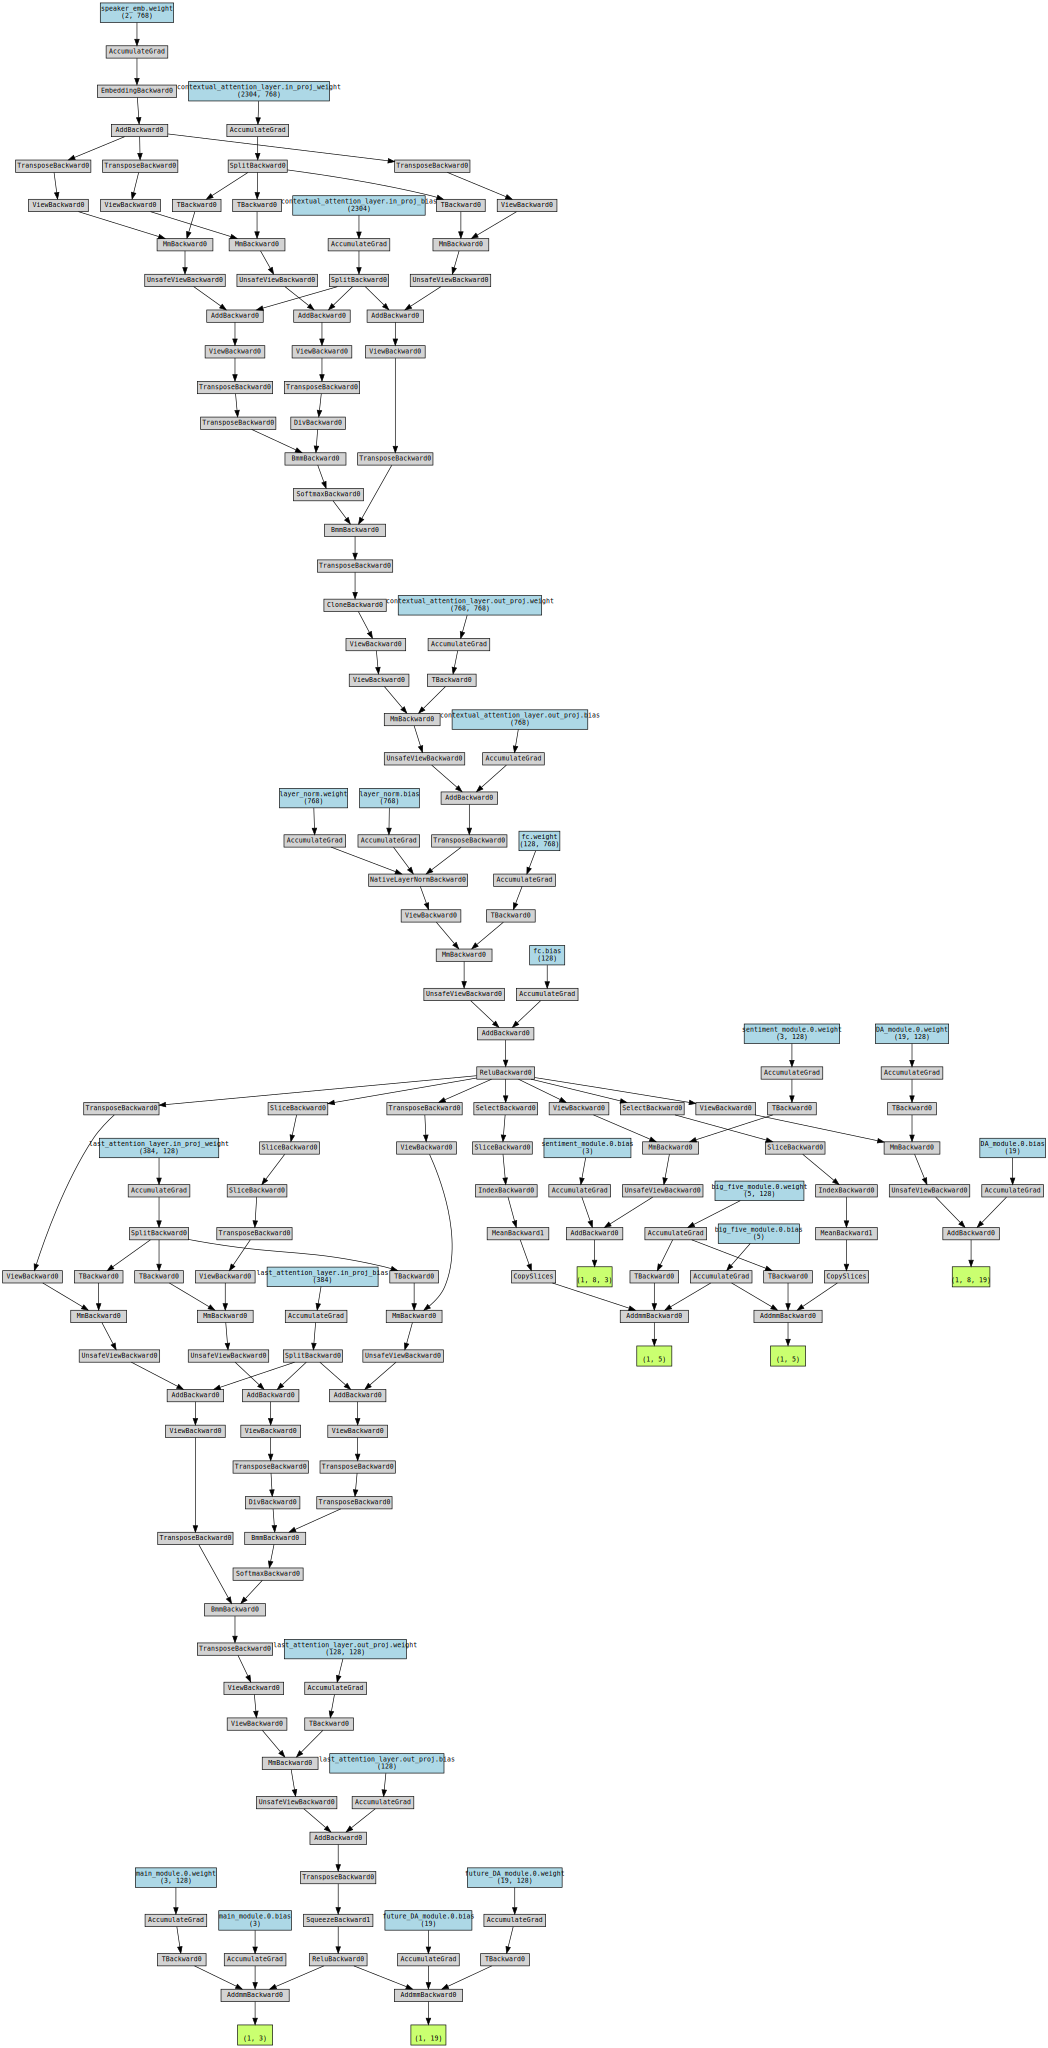

In [35]:
# Model Architecture
my_utils.plot_model_architecture(model, DEVICE)

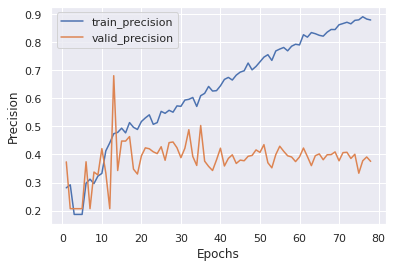

In [36]:
# Precision
my_utils.plot_result([train_precision_list], [valid_precision_list], ["precision"])

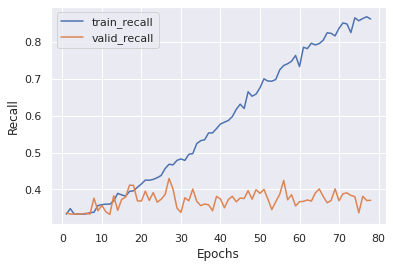

In [37]:
# Recall
my_utils.plot_result([train_recall_list], [valid_recall_list], ["recall"])

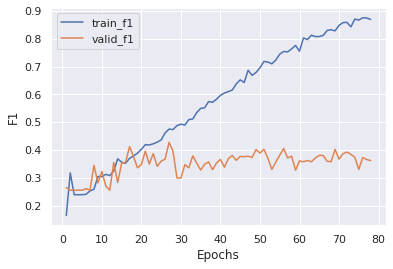

In [38]:
# F1-Score
my_utils.plot_result([train_f1_list], [valid_f1_list], ["f1"])

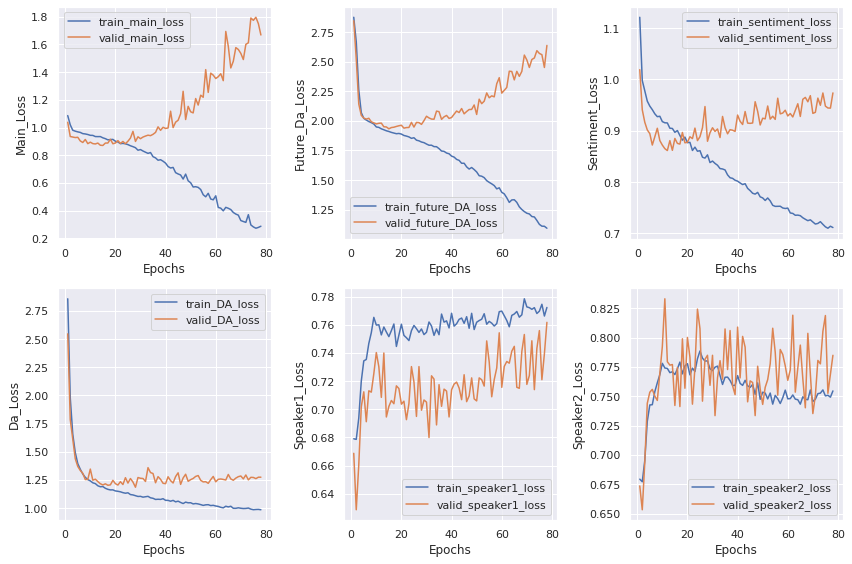

In [40]:
# Loss
assert train_loss_dict.keys() == valid_loss_dict.keys()
my_utils.plot_result(list(train_loss_dict.values()), list(valid_loss_dict.values()), list(train_loss_dict.keys()))

# Model Testing

In [41]:
def test(model):

    # Test Dataset
    test = Dataset(df=test_df, embeddings=test_embedding)
    
    # Test DataLoader
    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

    # Run the model on GPU
    model = model.to(DEVICE)
        
    # Set the state of the model to "Evaluation"
    model.eval()

    # To save the test result
    test_true = torch.tensor([])
    test_pred = torch.tensor([])

    # Test
    with torch.no_grad():

        # Test with batches
        for test_embeddings, test_main_labels, _, _, _, _, _, test_speaking_order in tqdm(test_dataloader):

            # Feed the data into the model
            test_embeddings = test_embeddings.to(DEVICE)
            test_main_labels = test_main_labels.to(DEVICE)
            test_speaking_order = test_speaking_order.to(DEVICE)
            main_output, _, _, _, _, _ = model(test_embeddings, test_speaking_order)
            main_output = torch.squeeze(main_output)
            
            # Calculate Score
            test_main_labels = test_main_labels.cpu()
            main_output = torch.argmax(main_output, dim=-1).cpu()

            # Save the result of each batch
            test_true = torch.cat([test_true, test_main_labels])
            test_pred = torch.cat([test_pred, main_output])

        # Calculate Metrics
        test_accuracy = accuracy_score(test_true, test_pred)
        test_precision = precision_score(test_true, test_pred, average='macro')
        test_recall = recall_score(test_true, test_pred, average='macro')
        test_f1 = f1_score(test_true, test_pred, average='macro')
        
    print(f"test_accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"test_precision: {round(test_precision * 100, 2)}%")
    print(f"test_recall: {round(test_recall * 100, 2)}%")
    print(f"test_f1: {round(test_f1 * 100, 2)}%")
    
    # Draw the result
    my_utils.plot_report(test_true, test_pred, list(LABEL_MAPPING.keys()))
    my_utils.plot_confusion_matrix(test_true, test_pred, list(LABEL_MAPPING.values()), list(LABEL_MAPPING.keys()))
        
    return test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred

In [42]:
model = Model()
model.load_state_dict(torch.load(MODEL_PATH))
# model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

100%|██████████| 49/49 [00:00<00:00, 104.49it/s]


test_accuracy: 43.72%
test_precision: 40.38%
test_recall: 40.14%
test_f1: 38.41%
              precision    recall  f1-score   support

     neutral     0.3017    0.5377    0.3866       385
    negative     0.6195    0.4970    0.5515       829
    positive     0.2902    0.1697    0.2141       330

    accuracy                         0.4372      1544
   macro avg     0.4038    0.4014    0.3841      1544
weighted avg     0.4699    0.4372    0.4383      1544



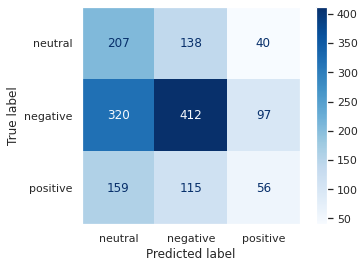

In [43]:
test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred = test(model)

In [52]:
reverse_mapping = {v: k for k, v in LABEL_MAPPING.items()}
for i in range(300):
    print(test_df.context[i])
    t, p = test_df.labels[i]['main_label'], int(test_pred[i])
    flag = "X" if t != p else ""
    print(f"True: {reverse_mapping[t]} ({t})")
    print(f"Pred: {reverse_mapping[p]} ({p}) {flag}")
    print(f"Next Sentence: {test_df.demo[i]}")
    print("="*70)

['語者一：是希望由我来控制整个婚礼的现场流程', '語者二：我想新娘委派我来担当这次婚礼的总导演', '語者二：是希望我来掌控现场的所有事情', '語者二：包括主持人', '語者一：好 好', '語者一：你既然已经看过了我的演讲稿和我的计划安排', '語者一：为什么你还', '語者一：你还没有看过对不对']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 谁说我没看过
['語者一：好 好', '語者一：你既然已经看过了我的演讲稿和我的计划安排', '語者一：为什么你还', '語者一：你还没有看过对不对', '語者二：谁说我没看过', '語者二：我只是觉得你的那套不是很合适这场婚礼', '語者二：哪个奇怪大叔写的旧社会婚礼方案 解放这么多年了', '語者二：不能用的']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 再怎么奇怪
['語者一：你说你弄那么多假洋鬼子来干嘛', '語者一：新郎新娘又不是外国人', '語者一：搞不清楚的还以为要嫁到墨西哥去', '語者二：这样子我说我要是弄点这企鹅过来', '語者二：新娘还得嫁到南极', '語者二：是不是', '語者二：你的方案好 一拜天 二拜地', '語者二：你这是结婚还是上坟对吧']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 中国传统 天经地义
['語者一：新郎新娘又不是外国人', '語者一：搞不清楚的还以为要嫁到墨西哥去', '語者二：这样子我说我要是弄点这企鹅过来', '語者二：新娘还得嫁到南极', '語者二：是不是', '語者二：你的方案好 一拜天 二拜地', '語者二：你这是结婚还是上坟对吧', '語者一：中国传统 天经地义']
True: positive (2)
Pred: negative (1) X
Next Sentence: 不好意思
['語者一：我也有请 我在节目里都做了广告了', '語者一：我最好的朋友要结婚', '語者一：会有很多我的粉丝来捧我的', '語者二：人家的粉丝名字多好听', '語者二：什么玉米凉粉的', '語者二：偏偏有个人的粉丝叫咸菜', '語者二：怎么听着都觉得让人寒酸的想掉眼泪', '語者一：

True: positive (2)
Pred: neutral (0) X
Next Sentence: 对我想是的
['語者一：不过你的声音怎么了', '語者一：听起来怪怪的', '語者二：是吗', '語者二：我嗓子有点不太舒服', '語者一：怎么了你病了', '語者二：对我想是的', '語者二：展博你知道吗', '語者二：我一直都在想你 想你想的肚子有点胀胀的']
True: negative (1)
Pred: negative (1) 
Next Sentence: 涨涨的
['語者一：听起来怪怪的', '語者二：是吗', '語者二：我嗓子有点不太舒服', '語者一：怎么了你病了', '語者二：对我想是的', '語者二：展博你知道吗', '語者二：我一直都在想你 想你想的肚子有点胀胀的', '語者一：涨涨的']
True: positive (2)
Pred: neutral (0) X
Next Sentence: 就是那种吃饱了撑的感觉
['語者一：是吗', '語者一：我嗓子有点不太舒服', '語者二：怎么了你病了', '語者一：对我想是的', '語者一：展博你知道吗', '語者一：我一直都在想你 想你想的肚子有点胀胀的', '語者二：涨涨的', '語者一：就是那种吃饱了撑的感觉']
True: positive (2)
Pred: negative (1) X
Next Sentence: 这样啊
['語者一：我嗓子有点不太舒服', '語者二：怎么了你病了', '語者一：对我想是的', '語者一：展博你知道吗', '語者一：我一直都在想你 想你想的肚子有点胀胀的', '語者二：涨涨的', '語者一：就是那种吃饱了撑的感觉', '語者二：这样啊']
True: positive (2)
Pred: neutral (0) X
Next Sentence: 其实我早就想打过来了
['語者一：对我想是的', '語者一：展博你知道吗', '語者一：我一直都在想你 想你想的肚子有点胀胀的', '語者二：涨涨的', '語者一：就是那种吃饱了撑的感觉', '語者二：这样啊', '語者一：其实我早就想打过来了', '語者一：刚才碰到点意外耽搁了']
True: negative (1)
Pred: neutral (0) X
Next Sentence: 什么意外


In [53]:
# def demo(demo_context: list):
#     demo_df = pd.DataFrame({"context": [demo_context, ], "labels": [{"speaking_order": [0,0,0,1,1,1]},]})
#     demo_embedding = my_utils.get_dialogues_embedding(demo_df, TOKENIZER, BERT, DEVICE)
#     demo_embedding = demo_embedding.to(DEVICE)
#     demo_output, _, _ = model(demo_embedding)
#     demo_output = int(torch.argmax(torch.squeeze(demo_output), dim=-1))
#     print(f"Context: {demo_context}")
#     print(f"Predict: {reverse_mapping[demo_output]} ({demo_output})")

In [54]:
# # Demo Example 1
# demo(['語者一：隨便你愛怎樣就去做吧', '語者一：我管不了你', '語者二：真是謝謝你'])
# demo(['語者一：你做得真不錯', '語者一：我想沒有人比你更適合這個職位了', '語者二：真是謝謝你'])

In [55]:
# # Demo Example 2
# demo(['語者一：我剛剛打翻牛奶', '語者一：灑得地上到處都是', '語者二：你真棒'])
# demo(['語者一：今天老師發考卷', '語者一：我考一百分', '語者二：你真棒'])

In [56]:
# # Demo Example 3
# demo(['語者一：我今天被老闆罵', '語者一：心情好差', '語者二：活該'])
# demo(['語者一：我今天被老闆罵', '語者一：心情好差', '語者二：那我們去吃大餐慰勞一下'])